A first example of machine learning
==
In this notebook we'll apply a scikit-learn pipeline to a simple dataset (the listing of apartments in Airbnb of Berlin), and see how overfitting looks like.

In [1]:
import numpy as np

We can invoke system commands by prepending them with a `!`, commands like `head`, `tail`, `wc` can be useful to quickly inspect a text file. Most of them are not present on Windows.

In [2]:
!head listings.csv

id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,cal

numpy provides the function `loadtxt` to load simple CSV files

In [ ]:
#np.loadtxt('listings.csv', delimiter=',', usecols=(54, 59, 48, 49, 79 ), skiprows=1)

It does not work because this file contains newlines inside the fields. Luckily the Python CSV module can still process it.

This code loads some columns from the CSV into separate numpy arrays.

First, we create plain Python lists, then replace them with proper arrays (faster and smaller).

Don;t worry: with Pandas this kind of operation becomes much easier.

In [4]:
from csv import DictReader

review_scores_rating = []
price = []
latitude = []
longitude = []
bathrooms = []

for l in DictReader(open('listings.csv', encoding = 'utf-8')):
    price.append(l['price'])
    review_scores_rating.append(l['review_scores_rating'])
    latitude.append(l['latitude'])
    longitude.append(l['longitude'])
    bathrooms.append(l['bathrooms'])

latitude = np.array([float(l) for l in latitude])
longitude = np.array([float(l) for l in longitude])
price = np.array([float(l[1:].replace(',', '')) for l in price])

# We assume the rating is 1 if not specified
review_scores_rating = np.array([int(l) if l != '' else 0 for l in review_scores_rating])

# We assume there's 1 bathroom if not stated otherwise
bathrooms = np.array([float(l) if l != '' else 1 for l in bathrooms])

It's very useful to have a look at the shape of the numpy arrays.

In [5]:
print(latitude.shape)
print(bathrooms.shape)

(22552,)
(22552,)


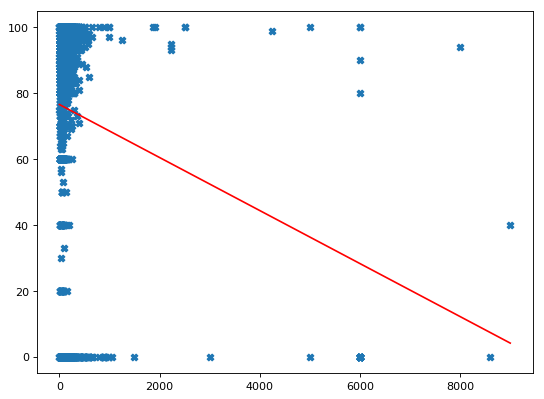

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# change the figure size
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80)

# reshape is needed to create a second dimension of size 1
X = price.T.reshape(-1, 1)
Y = review_scores_rating.T
model = LinearRegression()
model.fit(X, Y)
model.score(X,Y)


plt.scatter(X, Y, marker='X')

x_plot = np.linspace(0, 9000, 200)
y_plot = model.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, y_plot, color='red')

plt.show()

Turns out there are prices much much greater than the rest, making the visualization and the model less effective. Let's ignore them by placing a cap of 500 on the price.


In [7]:
too_high = np.argwhere(price > 500)
print(f'shape before: {price.shape}')
Ylow = np.delete(Y, too_high)
Xlow = np.delete(price, too_high).reshape(-1, 1)
print(f'shape after: {Xlow.shape}')

shape before: (22552,)
shape after: (22478, 1)


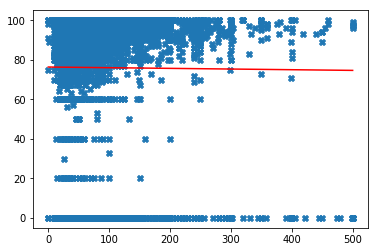

In [8]:
model = LinearRegression()
model.fit(Xlow, Ylow)
model.score(Xlow, Ylow)


plt.scatter(Xlow, Ylow, marker='X')

x_plot = np.linspace(0, 500, 200)
y_plot = model.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, y_plot, color='red')

plt.show()

In scikit you can combine models using `make_pipeline`, in this case we combine `PolynomialFeatures` with `LinearRegression`, to run a linear regression on the features generated by the first step, which are the original ones multiplied and to various powers.

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = np.vstack((latitude, longitude, bathrooms)).T
print(f'the shape of X is {X.shape}')
Y = review_scores_rating.T
print(f'the shape of Y is {Y.shape}')


for degree in range(1, 20):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, Y)
    score = model.score(X, Y)
    print(f'with degree {degree} the score was {score:.5f}')

the shape of X is (22552, 3)
the shape of Y is (22552,)
with degree 1 the score was 0.00013
with degree 2 the score was 0.00121
with degree 3 the score was 0.00177
with degree 4 the score was 0.00351
with degree 5 the score was 0.00439
with degree 6 the score was 0.00499
with degree 7 the score was 0.00543
with degree 8 the score was -0.00453
with degree 9 the score was 0.00595
with degree 10 the score was 0.00324
with degree 11 the score was 0.00534
with degree 12 the score was 0.00637
with degree 13 the score was 0.00606
with degree 14 the score was 0.00619
with degree 15 the score was 0.00469
with degree 16 the score was 0.00681
with degree 17 the score was -0.00351
with degree 18 the score was 0.00414
with degree 19 the score was 0.00513


The model reaches the best score at degree 11 (notice it could change with other cities) (Note 08.01.19: Degre 11 not valid anymore, was written before bugfix, now it's 16). This seems the best result, but what is happening here is that we have overfitting. The dataset we use to check the model is the same we used to train it.

Let's try instead by partitioning the data in train and test datasets.

In [10]:
train_X = X[:21000,:]
test_X = X[21000:,:]

train_Y = Y[:21000]
test_Y = Y[21000:]

for degree in range(1, 20):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(train_X, train_Y)
    score = model.score(test_X, test_Y)
    print(f'with degree {degree} the score was {score}')

with degree 1 the score was -0.45525427333824364
with degree 2 the score was -0.45329336376582274
with degree 3 the score was -0.45244814852495163
with degree 4 the score was -0.45034071573780693
with degree 5 the score was -0.5876503707761283
with degree 6 the score was -0.8794112720894256
with degree 7 the score was -0.8828181478917392
with degree 8 the score was -52.41232572536599
with degree 9 the score was -1145.9230589296028
with degree 10 the score was -5882.32949297316
with degree 11 the score was -4069.5799291980848
with degree 12 the score was -9373.587667341308
with degree 13 the score was -9804.53210900493
with degree 14 the score was -7555.832414068939
with degree 15 the score was -9854.973527835233
with degree 16 the score was -8279.512551157764
with degree 17 the score was -5528.35031456939
with degree 18 the score was -6919.940801977707
with degree 19 the score was -4139.057685135858


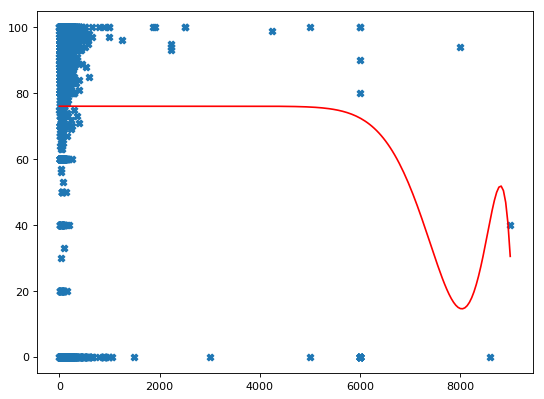

In [11]:
# change the figure size
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80)

# reshape is needed to create a second dimension of size 1
X = price.T.reshape(-1, 1)



model = make_pipeline(PolynomialFeatures(20), LinearRegression())
#model = LinearRegression()
model.fit(X, Y)
model.score(X,Y)



plt.scatter(X, Y, marker='X')

x_plot = np.linspace(0, 9000, 200)
y_plot = model.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, y_plot, color='red')

plt.show()

Turns out there are prices much much greater than the rest, making the visualization and the model pointless. Let's ignore them by placing a cap of 500 on the data.

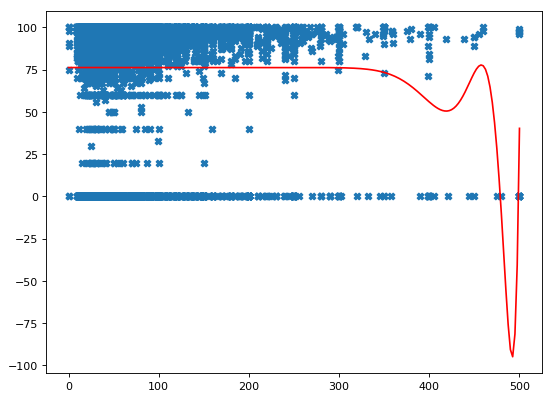

In [12]:
figure(num=None, figsize=(8, 6), dpi=80)


model = make_pipeline(PolynomialFeatures(30), LinearRegression())
#model = LinearRegression()
model.fit(Xlow, Ylow)
model.score(Xlow, Ylow)


plt.scatter(Xlow, Ylow, marker='X')

x_plot = np.linspace(0, 500, 200)
y_plot = model.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, y_plot, color='red')

plt.show()

Just for fun, let's draw a map of prices

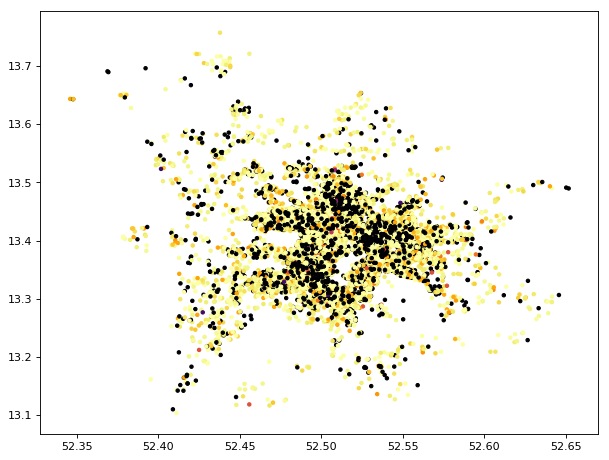

In [13]:
figure(num=None, figsize=(9, 7), dpi=80)

plt.scatter(latitude, longitude, c=review_scores_rating, marker='.', cmap=plt.cm.get_cmap('inferno'))